# Artificial Neural Network

The purpose of the following notebook is to provide a simple implementation to get hands on experience, and thus hopefully also a deeper understanding of the backwards error propagation approach to neural network. The task for the network is to classify iris set of data from [UCI](https://archive.ics.uci.edu/ml/datasets/Iris), and will thereby be a form of supervised learning.


## 1. Setting up the artificial network class [WIP]


In [353]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [318]:
def activation_function(x):
    """Calculates the activation of a node give an input

    Args:
        x (integer: Scalar) :  Number representing the sum of the input to the give node
    """
    return (1 + np.e**-x)**-1


def der_activation_function(x):

    return (np.e**-x)/((1+np.e**-x)**2)


activation = np.vectorize(activation_function)
der_activation = np.vectorize(der_activation_function)


In [319]:
def cost_function(prediction, solution):
    """Calculates the cost of a single sample

    Args:
        prediction (ndarray) : Output from the learner
        soution (ndarray) : Solution for the sample

    Returns: 
        float : Cost of the single training sample
    """
    return np.sum((prediction - solution)**2)


In [379]:
class ANN:
    def __init__(self, features, hidden_layers, outputs, learning_rate=0.01):
        """
        Takes as input
            hidden_layers : 1d array with number of neurons to include in each of the hidden layers
            features : int representing the number of features of the data set - corresponds to the first (input) layer
            outputs : int representing the number of possible outputs - and thereby number of nodes in the final (output) layer
        """

        # Meta data
        self.num_layers = len(hidden_layers) + 2
        self.num_outputs = outputs
        self.num_features = features
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate

        combined_layers = np.array([features] + hidden_layers + [outputs])

        # Setting up the layers
        self.layers = []
        self.deltas = []
        for num in combined_layers:
            self.layers.append([0 for _ in range(num)])
            self.deltas.append([0 for _ in range(num)])

        # Setting up weights and layer inputs
        self.layer_inputs = []
        self.weights = []
        #self.margins = []
        for i in range(len(combined_layers)-1):
            self.weights.append(np.random.rand(
                combined_layers[i], combined_layers[i+1]))
            #self.margins.append(np.zeros(np.shape((combined_layers[i], combined_layers[i+1]))))
            self.layer_inputs.append([0 for _ in range(combined_layers[i])])

    def reset(self):
        self.__init__(self.num_features, self.hidden_layers, self.num_outputs)

    def forward_pass(self, sample):
        """Fixes the neural network to a sample and generates the prediction at the output layer

        Args:
            sample (ndarray): Array of floats which represents the value of the input sample
        """
        self.layers[0] = sample

        # Iterate through each layer and calculate activation based on
        for i in range(1, self.num_layers):
            # Fetch the activation and weight of the previous layers
            prev_activation = self.layers[i-1]
            weights = self.weights[i-1]

            # Calculate inputs of the current nodes based on activation of previous and weights between them
            self.layer_inputs[i-1] = np.dot(weights.T, prev_activation)

            # Update current layer with activation of inputs
            self.layers[i] = activation(self.layer_inputs[i-1])

    def predict(self, sample):
        """Predicts the label of a sample x

        Args:
            sample (ndarray): Array of integers which represents the first input layer of the network

        Returns:
            ndarray: Array of floats which represent the confidences of the classification for each category of the output
        """
        self.forward_pass(sample)
        return self.layers[-1]

    def backprops_error(self, solution):
        """Compares a prediction to a solution and calculates the error between the layer and the expected values
        (Propagates the deltas down the network from the output)

        Args:
            prediction (ndarray): Prediction, output of the network for some sample x
            solution (ndarray): The solution to the sample fetched from the dataset
        """
        
        # Calculate error of output layer
        self.deltas[-1] = der_activation(self.layer_inputs[-1]) * (self.layers[-1] - solution)

        # Iterate from outputlayer backwards and propagate error
        for i in range(len(self.weights) - 1, 0, -1):
            self.deltas[i] = der_activation(self.layer_inputs[i-1]) * np.dot(self.weights[i], self.deltas[i + 1])

            #self.margins[i] = self.learning_rate * self.layers[i] * der_activation(self.layer_inputs[i]) * self.deltas[i + 1]

    def update_network(self, solution):
        """Calculates the margins of weights for the network given a traning example, and updates the weights accordingly
        """
        for i in range(len(self.weights)):
            margins = -self.learning_rate * np.outer(self.layers[i], self.deltas[i + 1].T)
            self.weights[i] = self.weights[i] + margins

    def train_sample(self, sample, solution): 
        """Trains the network on a single sample

        Args:
            sample (ndarray(4,)): Sample to make prediction on
            solution (ndarray(3,)): Solution to the respective sample passed
        """
        assert len(sample) == self.num_features
        assert len(solution) == self.num_outputs
        
        self.predict(sample)
        self.backprops_error(solution)
        self.update_network(solution)

    def train(self, samples, solutions):
        """Trains the network on a set of samples and respective solutions

        Args:
            samples (ndarray(n,)): Set of samples for the network to make predictions on and train for
            solutions (ndarray(n,)): Set of respective solutions to the samples
        """
        assert len(samples) == len(solutions)

        for sample, solution in zip(samples, solutions):
            self.train_sample(sample, solution)

    def test_sample(self, sample, solution):
        """Tests a single sample and returns the squared error

        Args:
            sample (ndarray(num_features,)): Sample to predict and find error for
            solution (ndarray(num_outputs)): Solutions to respective example

        Returns:
            float: Squared error over solution
        """
        assert len(sample) == self.num_features
        assert len(solution) == self.num_outputs

        return np.sum((self.predict(sample) - solution)**2)

    def test(self, samples, solutions):
        """Test the perfomance of the network on a dataset

        Args:
            samples ((ndarray(n,))): Set of samples
            solutions (ndarray(n,)): Set of solutions to respective examples

        Returns:
            ndarray: 
        """
        assert len(samples) == len(solutions)

        error = np.array([])

        for sample, solution in zip(samples, solutions):
            sample_error = self.test_sample(sample, solution)
            error = np.append(error, sample_error)

        return error

## Preprocessing data

The data is loaded from `./data/iris.data` and utilizes `pandas` to preprocess it. This includes splitting the attributes and the labels, and converting the categorical label to integers.


In [380]:
# Loading from file
df = pd.read_csv('./data/iris.data',
                 names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']).sample(frac=1)
y = df['label']
x = df.drop(['label'], axis=1)


In [381]:
# Converting labels from string to integers representing categories
uniques = y.unique()
label_map = {i: uniques[i] for i in range(len(uniques))}
y.replace(uniques, [i for i in range(len(uniques))], inplace=True)


In [382]:
y_train = y.iloc[0:110]
y_test = y.iloc[110:]

x_train = x.iloc[0:110]
x_test = x.iloc[110:]

## Setting up network and making predictions [WIP]

With the data loaded, the model is ready to be set up and make predictions based on the provided samples from the dataset.


In [429]:
# Setting up network based on metadata
model_hidden_layers = [10, 6]

ann = ANN(len(x.columns), model_hidden_layers, len(uniques), learning_rate=0.05)


In [430]:
# Creating arrays with solutions for easier error calculation
solutions_train = []

for _, solution in y_train.items():

    solutions_train.append([1 if i == solution else 0 for i in range(len(uniques))])

solutions_test = []

for _, solutions in y_test.items():
    solutions_test.append([1 if i == solutions else 0 for i in range(len(uniques))])


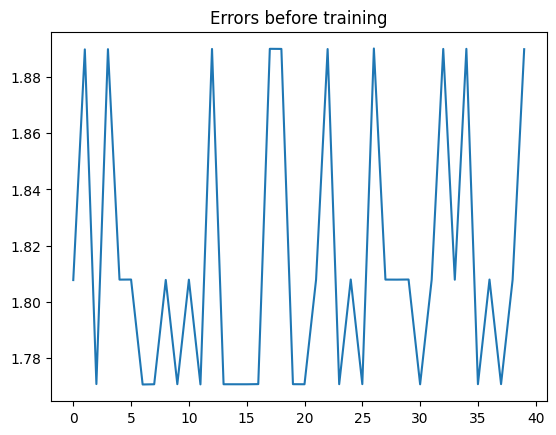

In [431]:
before_errors = ann.test(x_test.to_numpy(), solutions_test)
plt.plot(before_errors)
plt.title('Errors before training')
plt.show()

In [432]:
epochs = 3000
sample_interval = 100 

checkpoints = []
ann.reset()

for i in range(epochs):
    if not i % sample_interval: 
        print(f'Finished epoch {i}')
        errors = ann.test(x_test.to_numpy(), solutions_test)
        checkpoints.append(np.mean(errors))
    ann.train(x_train.to_numpy(), solutions_train)

Finished epoch 0
Finished epoch 100
Finished epoch 200
Finished epoch 300
Finished epoch 400
Finished epoch 500
Finished epoch 600
Finished epoch 700
Finished epoch 800
Finished epoch 900
Finished epoch 1000
Finished epoch 1100
Finished epoch 1200
Finished epoch 1300
Finished epoch 1400
Finished epoch 1500
Finished epoch 1600
Finished epoch 1700
Finished epoch 1800
Finished epoch 1900
Finished epoch 2000
Finished epoch 2100
Finished epoch 2200
Finished epoch 2300
Finished epoch 2400
Finished epoch 2500
Finished epoch 2600
Finished epoch 2700
Finished epoch 2800
Finished epoch 2900


In [433]:
from plyer import notification

notification.notify(
    title='Visual Studio Code', 
    message='Finished training network',
    timeout=2
)

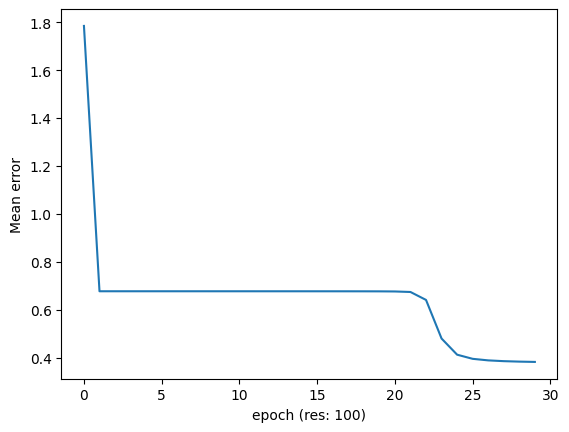

In [439]:
plt.plot(checkpoints)
plt.xlabel(f'epoch (res: {sample_interval})')
plt.ylabel("Mean error")
plt.show()

### Verification on test set

In [435]:
# Verification on test 
errors = ann.test(x_test.to_numpy(), solutions_test)

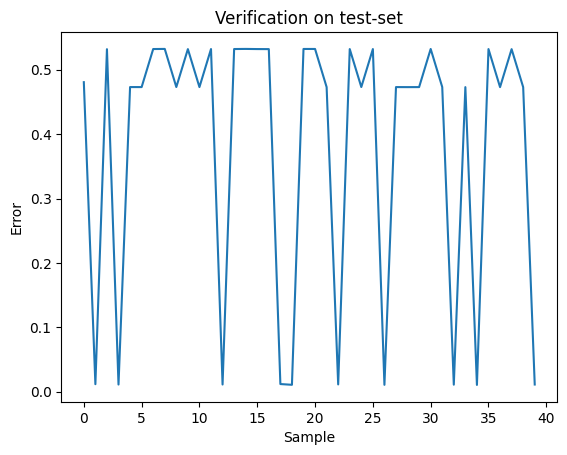

In [436]:
plt.plot(errors)
plt.title("Verification on test-set")
plt.ylabel("Error")
plt.xlabel("Sample")
plt.show()

### Verification on training set

In [437]:
# Verification on train
errors = ann.test(x_train.to_numpy(), solutions_train)

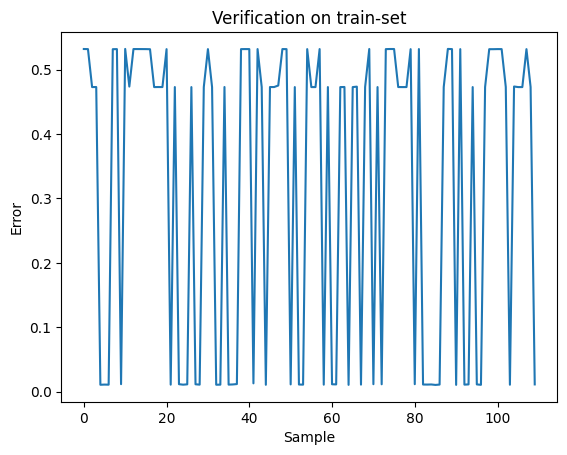

In [438]:
plt.plot(errors)
plt.title("Verification on train-set")
plt.ylabel("Error")
plt.xlabel("Sample")
plt.show()